# Introduction

- Goal
  - RNN과 LSTM을 활용해 주식 종가를 예측해보자

- Task
  - Task1.1: RNN을 활용한 삼성전자 종가 예측
  - Task1.2: LSTM을 활용한 삼성전자 종가 예측
  - Task2.1: RNN을 활용한 Tesla 종가 예측
  - Task2.2: LSTM을 활용한 Tesla 종가 예측

- Basic Information

  - Date: 날짜 - 주식 시장의 거래가 이루어진 날짜
  - Open: 시가 - 해당 거래일의 주식 시장이 개장할 때의 주식 가격
  - High: 고가 - 해당 거래일 동안 주식이 거래된 최고 가격
  - Low: 저가 - 해당 거래일 동안 주식이 거래된 최저 가격
  - Close: 종가 - 해당 거래일의 주식 시장이 폐장할 때의 주식 가격. 이는 당일의 마지막 거래 가격을 의미.
  - Adj Close: 수정 종가 - 주식 배당, 분할, 배분, 기타 조정 등을 반영한 종가. 주식의 실제 가치 정확히 반영하기 위해 사용.
  - Volume: 거래량 - 해당 거래일 동안 거래된 주식의 총 수량. 이는 해당 주식의 유동성을 나타내는 지표로 사용.

- TMI
  - 종목 선정 근거: 글쓴이가 거의(?) 유일하게 보유한 주식이 Tesla이기 때문
  - finance-datareader와 증권사 데이터(삼성증권) 간에 일부 오차가 존재한다. 원인이 무엇일까?

In [ ]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 1.3 MB/s eta 0:00:00


# 1.1 RNN을 활용한 삼성전자 종가 예측

## 1. Install packages & Load data

In [ ]:
import FinanceDataReader as fdr

In [ ]:
# 삼성전자 설정, 기간은 올해 초부터 현재까지
df = fdr.DataReader('005930', '2024-01-01', '2024-07-16')

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-01-02,78200,79800,78200,79600,17142847,0.014013
2024-01-03,78500,78800,77000,77000,21753644,-0.032663
2024-01-04,76100,77300,76100,76600,15324439,-0.005195
2024-01-05,76700,77100,76400,76600,11304316,0.000000
2024-01-08,77000,77500,76400,76500,11088724,-0.001305


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 2024-01-02 to 2024-07-16
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    133 non-null    int64  
 1   High    133 non-null    int64  
 2   Low     133 non-null    int64  
 3   Close   133 non-null    int64  
 4   Volume  133 non-null    int64  
 5   Change  133 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 7.3 KB


In [ ]:
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-07-10,87600,88000,87100,87800,17813847,0.000000
2024-07-11,88500,88800,86700,87600,24677608,-0.002278
2024-07-12,85900,86100,84100,84400,26344386,-0.036530
2024-07-15,84700,87300,84100,86700,25193080,0.027251
2024-07-16,86900,88000,86700,87700,16166688,0.011534


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

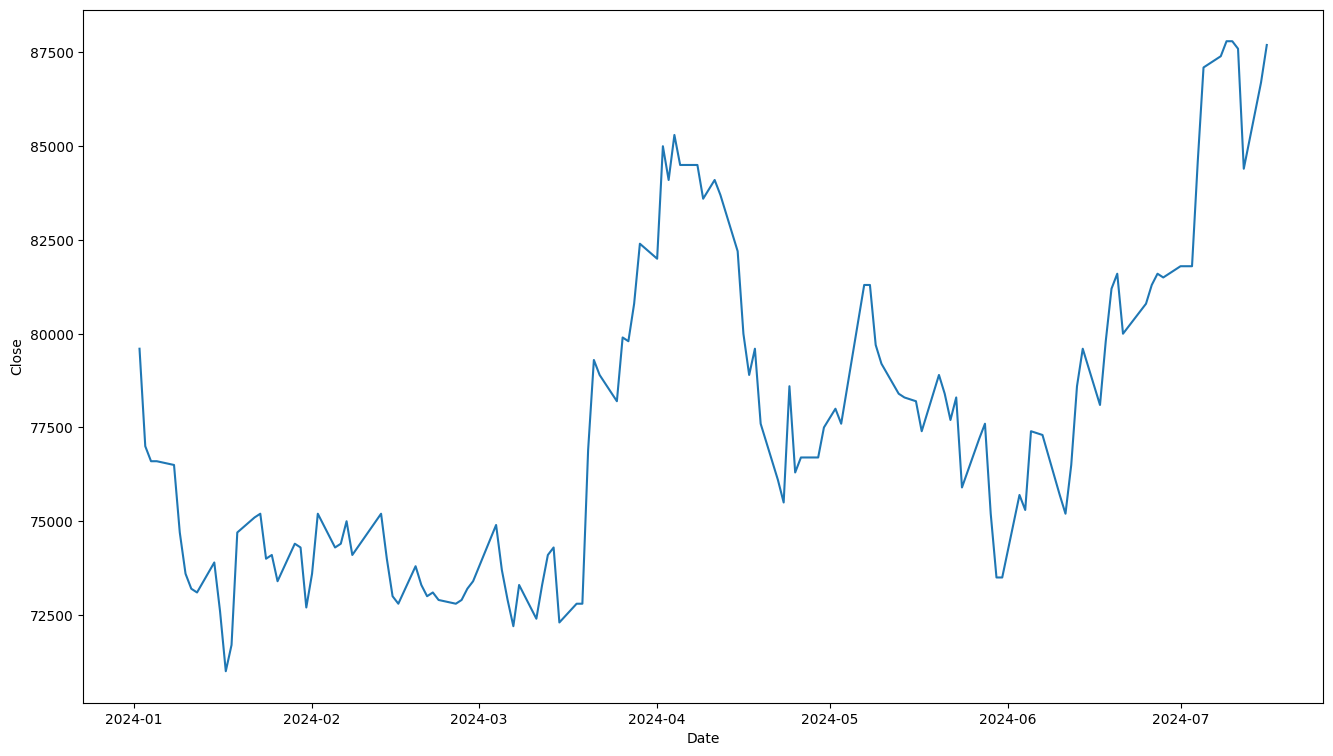

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

##2. Data preprocessing

In [ ]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [ ]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [ ]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

<ipython-input-11-650847349e00>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([128, 5, 4]) torch.Size([128, 1])
torch.Size([0, 5, 4]) torch.Size([0, 1])


In [ ]:
x_train_seq

tensor([[[0.3905, 0.4643, 0.4573, 0.1594],
         [0.4083, 0.4048, 0.3841, 0.2550],
         [0.2663, 0.3155, 0.3293, 0.1217],
         [0.3018, 0.3036, 0.3476, 0.0383],
         [0.3195, 0.3274, 0.3476, 0.0339]],

        [[0.4083, 0.4048, 0.3841, 0.2550],
         [0.2663, 0.3155, 0.3293, 0.1217],
         [0.3018, 0.3036, 0.3476, 0.0383],
         [0.3195, 0.3274, 0.3476, 0.0339],
         [0.3432, 0.3393, 0.2195, 0.3434]],

        [[0.2663, 0.3155, 0.3293, 0.1217],
         [0.3018, 0.3036, 0.3476, 0.0383],
         [0.3195, 0.3274, 0.3476, 0.0339],
         [0.3432, 0.3393, 0.2195, 0.3434],
         [0.2012, 0.1905, 0.1524, 0.2240]],

        ...,

        [[0.8284, 0.8988, 0.8841, 0.7533],
         [0.9645, 0.9881, 0.9878, 0.3023],
         [0.9586, 0.9643, 0.9878, 0.2463],
         [0.9467, 0.9524, 1.0000, 0.1733],
         [1.0000, 1.0000, 0.9756, 0.3156]],

        [[0.9645, 0.9881, 0.9878, 0.3023],
         [0.9586, 0.9643, 0.9878, 0.2463],
         [0.9467, 0.9524, 1.0000

In [ ]:
# x_train_seq와 y_train_seq를 TensorDataset으로 묶어서 train 데이터셋 생성
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)

# x_test_seq와 y_test_seq를 TensorDataset으로 묶어서 test 데이터셋 생성
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

# 배치 크기 설정
batch_size = 5

# train 데이터셋을 DataLoader로 변환, 배치 크기와 shuffle 옵션 설정
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)

# test 데이터셋을 DataLoader로 변환, 배치 크기 설정 (shuffle 옵션 없음)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size)


In [ ]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # RNN 층 정의 (입력 크기, 은닉층 크기, 레이어 수, batch_first 옵션)
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

    # 전결합 층 정의 (RNN 출력 크기를 1로 줄이고 Sigmoid 함수 적용)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())

  def forward(self, x):
    # 초기 은닉 상태를 0으로 설정 (레이어 수, 배치 크기, 은닉층 크기)
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)

    # RNN 층을 거친 출력과 은닉 상태 계산
    out, _ = self.rnn(x, h0)

    # RNN 출력을 (배치 크기, 나머지 차원)으로 reshape
    out = out.reshape(out.shape[0], -1)

    # reshape된 출력을 전결합 층으로 전달하여 최종 출력 계산
    out = self.fc(out)

    return out


In [ ]:
# VanillaRNN 모델 인스턴스 생성
# 모델 인스턴스를 지정된 입력 크기, 은닉층 크기, 시퀀스 길이, 레이어 수, 장치로 초기화
model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device) # 모델을 지정된 장치로 이동 (GPU)


In [ ]:
# 손실 함수로 평균 제곱 오차 (MSE) 사용
criterion = nn.MSELoss()

# 학습할 에포크 수 설정
num_epochs = 50

# Adam 옵티마이저 사용, 학습률은 0.001로 설정
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## 3. Modeling

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0688
[epoch : 10] loss: 0.0164
[epoch : 20] loss: 0.0121
[epoch : 30] loss: 0.0104
[epoch : 40] loss: 0.0094


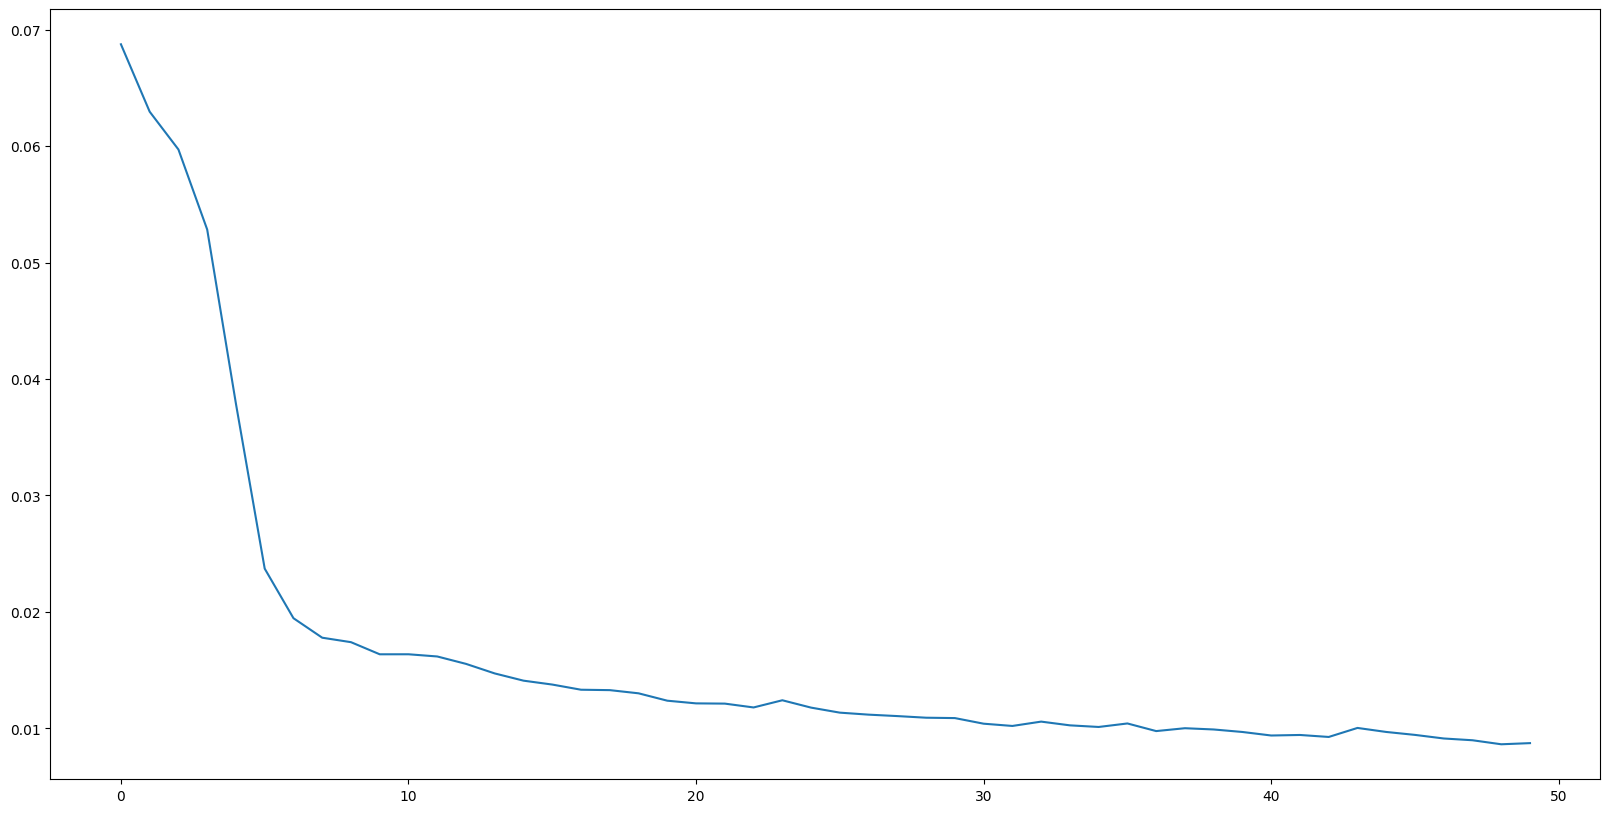

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [ ]:
# 실제 값과 예측값 비교
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

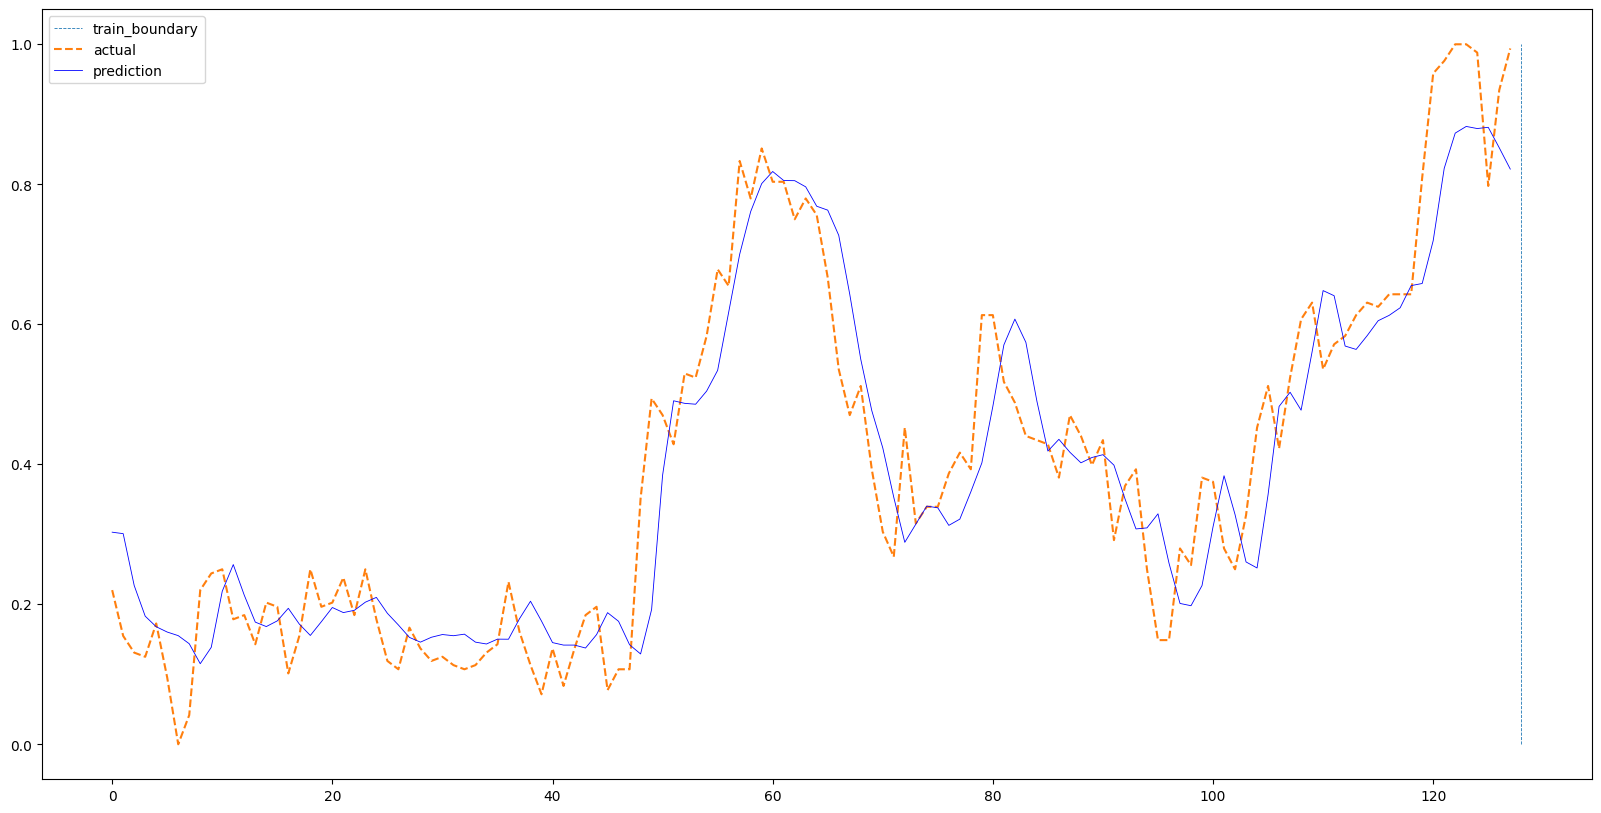

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# 1.2 LSTM을 활용한 삼성전자 종가 예측


- 1. Import packages&load data 2.datapreprocess 과정은 이전과 동일하여 생략

## 3.Modeling

In [ ]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # LSTM 층 정의 (입력 크기, 은닉층 크기, 레이어 수, batch_first 옵션)
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    # 전결합 층 정의 (LSTM 출력 크기를 1로 줄임)
    self.fc = nn.Linear(hidden_size * sequence_length, 1)

  def forward(self, x):
    # 초기 은닉 상태와 셀 상태를 0으로 설정 (레이어 수, 배치 크기, 은닉층 크기)
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)

    # LSTM 층을 거친 출력과 (은닉 상태, 셀 상태) 계산
    out, _ = self.lstm(x, (h0, c0))

    # LSTM 출력을 (배치 크기, 나머지 차원)으로 reshape
    out = out.reshape(out.shape[0], -1)

    # reshape된 출력을 전결합 층으로 전달하여 최종 출력 계산
    out = self.fc(out)

    return out


In [ ]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [ ]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 손실값을 저장할 리스트 초기화
loss_graph = []

# train_loader의 데이터 개수
n = len(train_loader)

# 지정된 에포크 수만큼 반복
for epoch in range(num_epochs):
    running_loss = 0.0  # 에포크 동안의 누적 손실 초기화

    # train_loader에서 배치 데이터 반복
    for data in train_loader:
        seq, target = data  # 배치 데이터 (입력 시퀀스, 목표 값)

        # 모델 예측값 계산
        out = model(seq)

        # 손실 계산
        loss = criterion(out, target)

        # 옵티마이저의 그래디언트 초기화
        optimizer.zero_grad()

        # 역전파를 통해 그래디언트 계산
        loss.backward()

        # 옵티마이저를 통해 가중치 갱신
        optimizer.step()

        # 누적 손실 계산
        running_loss += loss.item()

    # 에포크 당 평균 손실을 리스트에 추가
    loss_graph.append(running_loss / n)

    # 10 에포크마다 손실 출력
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' % (epoch, running_loss / n))


[epoch: 0] loss: 0.1642
[epoch: 10] loss: 0.0169
[epoch: 20] loss: 0.0145
[epoch: 30] loss: 0.0125
[epoch: 40] loss: 0.0099


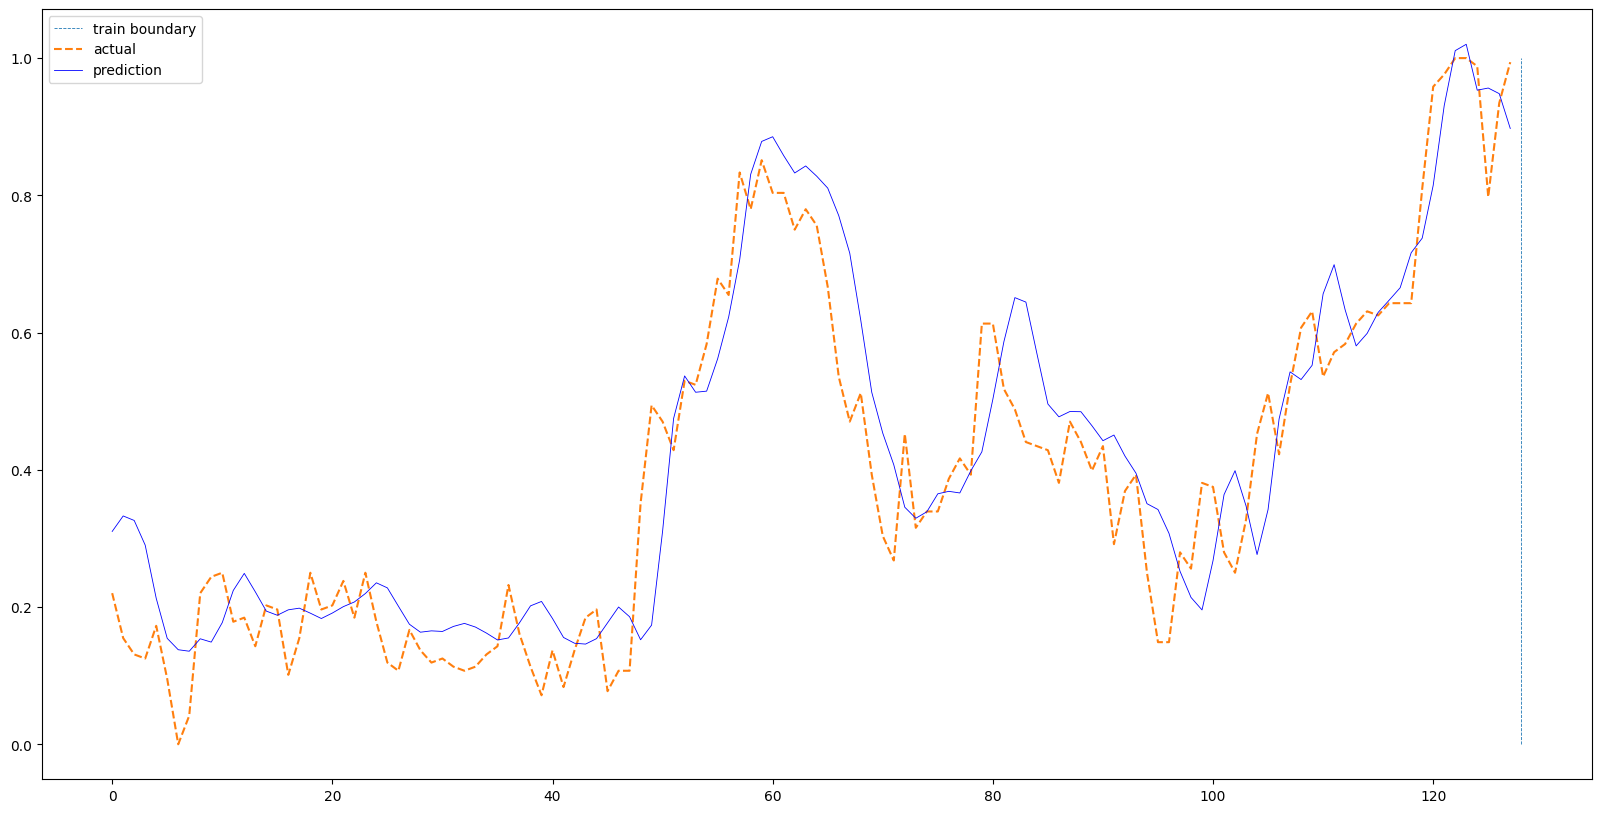

In [ ]:
# train과 test 데이터셋을 하나로 합침
concatdata = torch.utils.data.ConcatDataset([train, test])

# 합쳐진 데이터셋을 DataLoader로 변환, 배치 크기는 100으로 설정, shuffle 옵션은 False
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

# 모델 평가 모드로 설정, 그래디언트 계산 비활성화
with torch.no_grad():
    pred = []  # 예측값을 저장할 리스트 초기화
    model.eval()  # 모델 평가 모드 설정

    # 데이터 로더에서 배치 데이터 반복
    for data in data_loader:
        seq, target = data  # 배치 데이터 (입력 시퀀스, 목표 값)

        # 모델 예측값 계산
        out = model(seq)

        # 예측값을 리스트에 추가 (CPU로 이동하여 리스트 형태로 변환)
        pred += out.cpu().tolist()

# 시각화 설정
plt.figure(figsize=(20,10))

# train 데이터와 test 데이터 경계를 점선으로 표시
plt.plot(np.ones(100) * len(train), np.linspace(0, 1, 100), '--', linewidth=0.6)

# 실제 'Close' 값 점선으로 표시 (시퀀스 길이 이후 값)
plt.plot(df['Close'][sequence_length:].values, '--')

# 예측값 파란색 실선으로 표시
plt.plot(pred, 'b', linewidth=0.6)

# 범례 추가
plt.legend(['train boundary', 'actual', 'prediction'])

# 그래프 출력
plt.show()


# 2.1 RNN을 활용한 Tesla 종가 예측


## 1. Install packages & Load data

In [ ]:
# Tesla로 종목번호 변경. 미국시장이라 기간 일부 조정.
df = fdr.DataReader('TSLA', '2024-01-01', '2024-07-14')


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,250.080002,251.250000,244.410004,248.419998,248.419998,104654200
2024-01-03,244.979996,245.679993,236.320007,238.449997,238.449997,121082600
2024-01-04,239.250000,242.699997,237.729996,237.929993,237.929993,102629300
2024-01-05,236.860001,240.119995,234.899994,237.490005,237.490005,92379400
2024-01-08,236.139999,241.250000,235.300003,240.449997,240.449997,85166600


In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-07-08,247.710007,259.440002,244.570007,252.940002,252.940002,157219600
2024-07-09,251.000000,265.609985,250.300003,262.329987,262.329987,160210900
2024-07-10,262.799988,267.589996,257.859985,263.260010,263.260010,128519400
2024-07-11,263.299988,271.000000,239.649994,241.029999,241.029999,221707300
2024-07-12,235.800003,251.839996,233.089996,248.229996,248.229996,155694400


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 2024-01-02 to 2024-07-16
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    133 non-null    int64  
 1   High    133 non-null    int64  
 2   Low     133 non-null    int64  
 3   Close   133 non-null    int64  
 4   Volume  133 non-null    int64  
 5   Change  133 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 7.3 KB


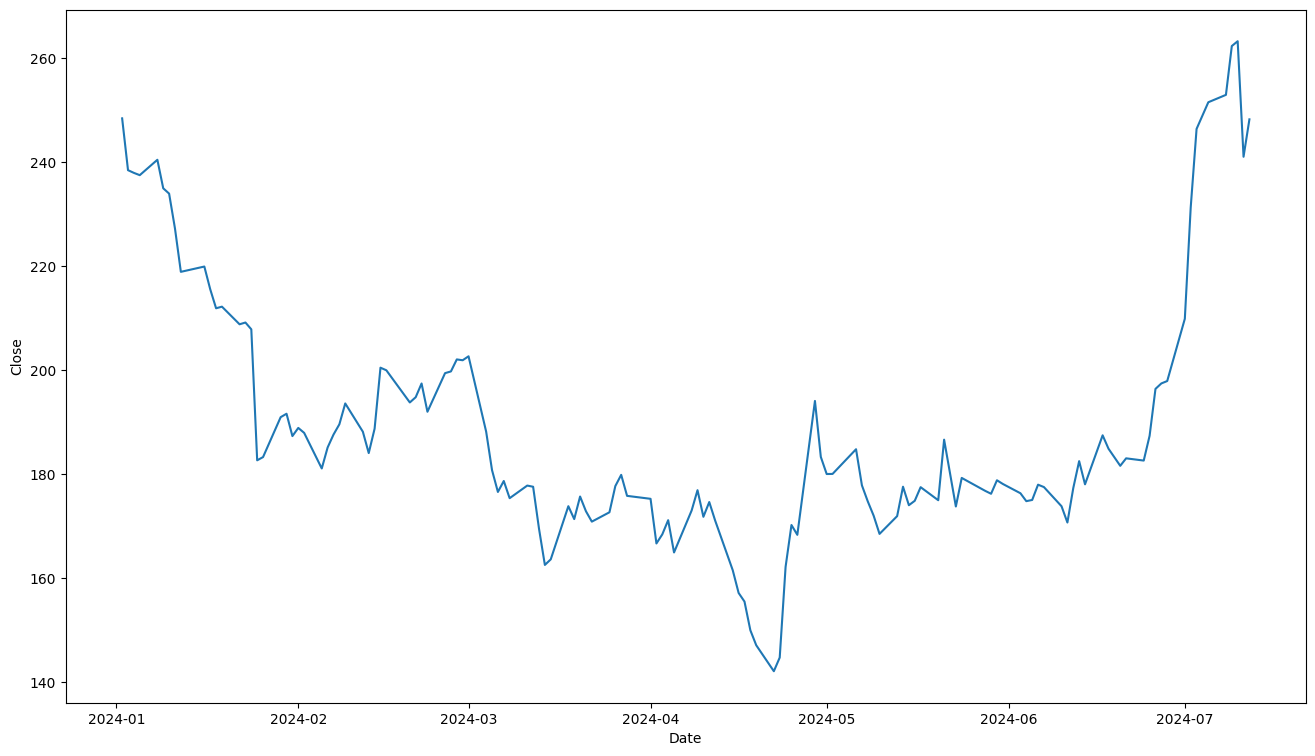

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

##2. Data preprocessing

In [ ]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [ ]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [ ]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([128, 5, 4]) torch.Size([128, 1])
torch.Size([0, 5, 4]) torch.Size([0, 1])


In [ ]:
# x_train_seq와 y_train_seq를 TensorDataset으로 묶어서 train 데이터셋 생성
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)

# x_test_seq와 y_test_seq를 TensorDataset으로 묶어서 test 데이터셋 생성
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

# 배치 크기 설정
batch_size = 5

# train 데이터셋을 DataLoader로 변환, 배치 크기와 shuffle 옵션 설정
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)

# test 데이터셋을 DataLoader로 변환, 배치 크기 설정 (shuffle 옵션 없음)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size)


In [ ]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # RNN 층 정의 (입력 크기, 은닉층 크기, 레이어 수, batch_first 옵션)
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

    # 전결합 층 정의 (RNN 출력 크기를 1로 줄이고 Sigmoid 함수 적용)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())

  def forward(self, x):
    # 초기 은닉 상태를 0으로 설정 (레이어 수, 배치 크기, 은닉층 크기)
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)

    # RNN 층을 거친 출력과 은닉 상태 계산
    out, _ = self.rnn(x, h0)

    # RNN 출력을 (배치 크기, 나머지 차원)으로 reshape
    out = out.reshape(out.shape[0], -1)

    # reshape된 출력을 전결합 층으로 전달하여 최종 출력 계산
    out = self.fc(out)

    return out


In [ ]:
# VanillaRNN 모델 인스턴스 생성
# 모델 인스턴스를 지정된 입력 크기, 은닉층 크기, 시퀀스 길이, 레이어 수, 장치로 초기화
model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device) # 모델을 지정된 장치로 이동 (GPU)


In [ ]:
# 손실 함수로 평균 제곱 오차 (MSE) 사용
criterion = nn.MSELoss()

# 학습할 에포크 수 설정
num_epochs = 50

# Adam 옵티마이저 사용, 학습률은 0.001로 설정
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## 3. Modeling

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0471
[epoch : 10] loss: 0.0126
[epoch : 20] loss: 0.0092
[epoch : 30] loss: 0.0066
[epoch : 40] loss: 0.0055


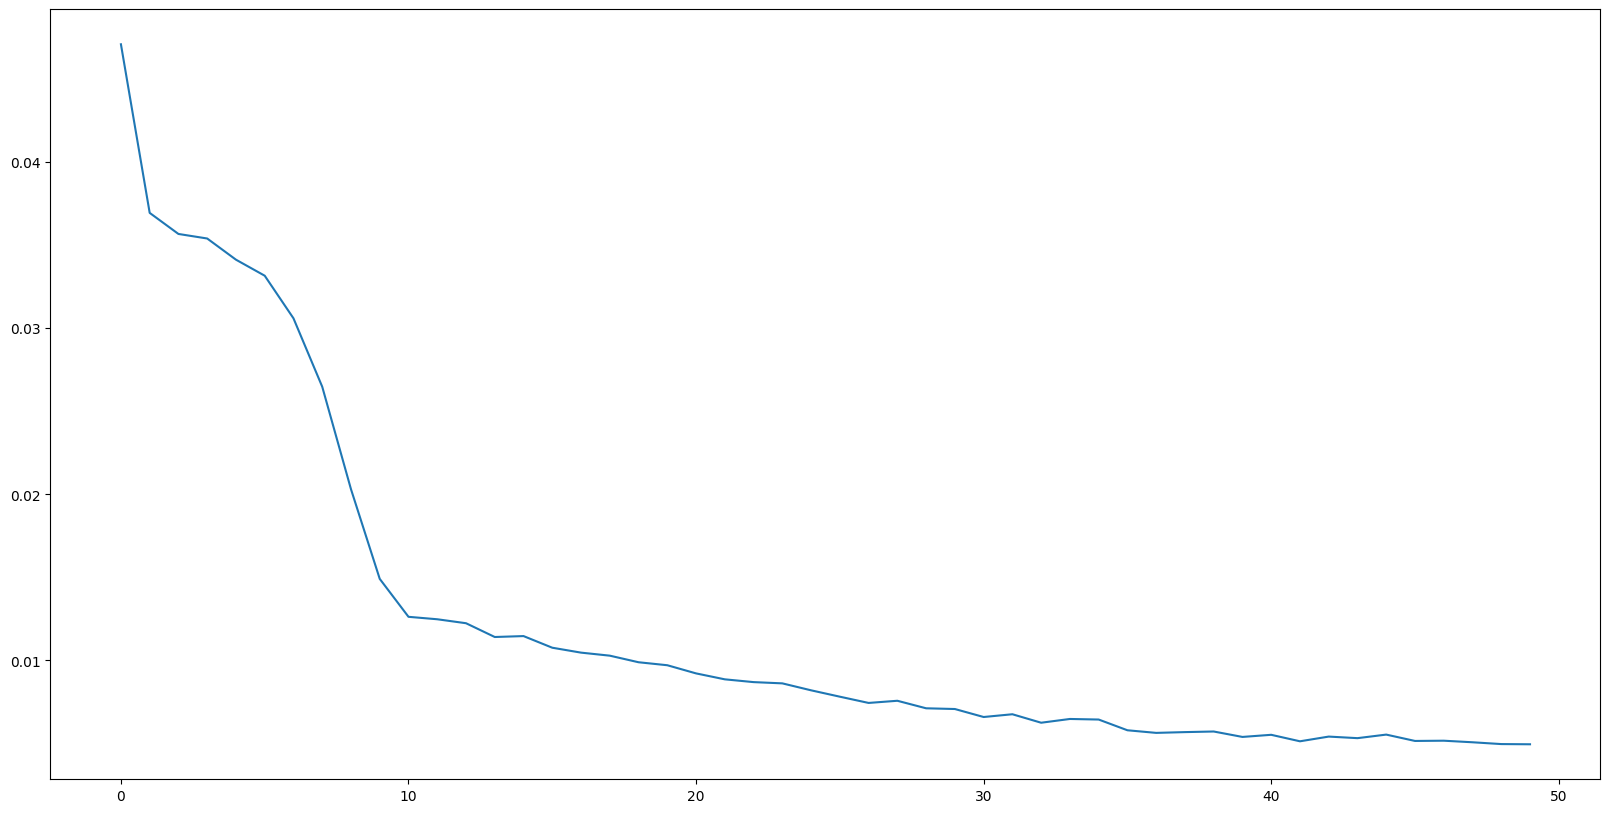

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [ ]:
# 실제 값과 예측값 비교
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

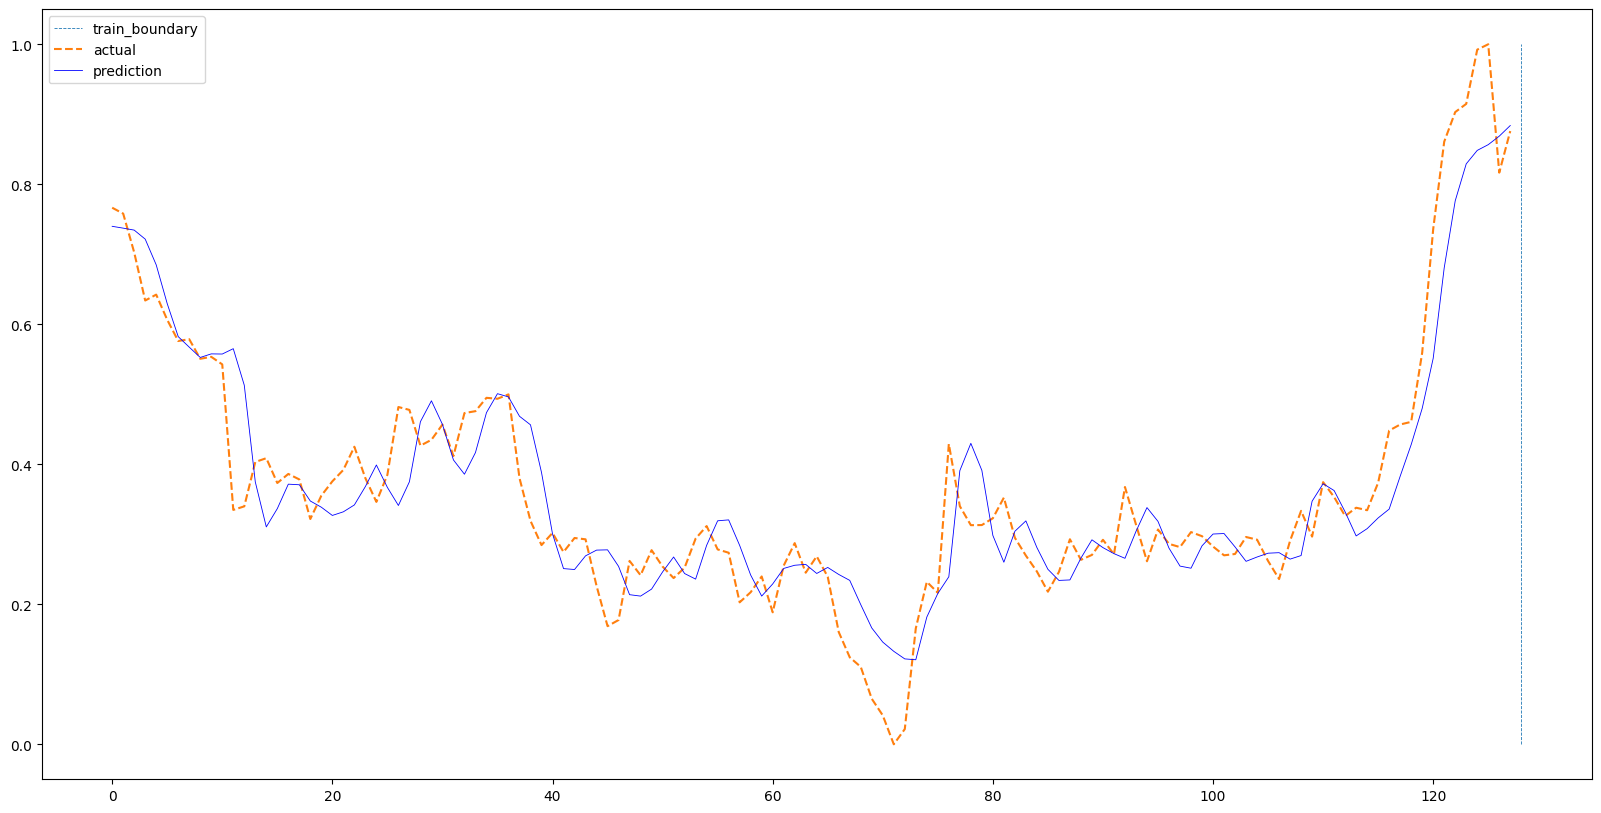

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# 2.2 LSTM을 활용한 Tesla 종가 예측


- 1. Import packages&load data 2.datapreprocess 과정은 이전과 동일하여 생략

## 3.Modeling

In [ ]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # LSTM 층 정의 (입력 크기, 은닉층 크기, 레이어 수, batch_first 옵션)
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    # 전결합 층 정의 (LSTM 출력 크기를 1로 줄임)
    self.fc = nn.Linear(hidden_size * sequence_length, 1)

  def forward(self, x):
    # 초기 은닉 상태와 셀 상태를 0으로 설정 (레이어 수, 배치 크기, 은닉층 크기)
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)

    # LSTM 층을 거친 출력과 (은닉 상태, 셀 상태) 계산
    out, _ = self.lstm(x, (h0, c0))

    # LSTM 출력을 (배치 크기, 나머지 차원)으로 reshape
    out = out.reshape(out.shape[0], -1)

    # reshape된 출력을 전결합 층으로 전달하여 최종 출력 계산
    out = self.fc(out)

    return out


In [ ]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [ ]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 손실값을 저장할 리스트 초기화
loss_graph = []

# train_loader의 데이터 개수
n = len(train_loader)

# 지정된 에포크 수만큼 반복
for epoch in range(num_epochs):
    running_loss = 0.0  # 에포크 동안의 누적 손실 초기화

    # train_loader에서 배치 데이터 반복
    for data in train_loader:
        seq, target = data  # 배치 데이터 (입력 시퀀스, 목표 값)

        # 모델 예측값 계산
        out = model(seq)

        # 손실 계산
        loss = criterion(out, target)

        # 옵티마이저의 그래디언트 초기화
        optimizer.zero_grad()

        # 역전파를 통해 그래디언트 계산
        loss.backward()

        # 옵티마이저를 통해 가중치 갱신
        optimizer.step()

        # 누적 손실 계산
        running_loss += loss.item()

    # 에포크 당 평균 손실을 리스트에 추가
    loss_graph.append(running_loss / n)

    # 10 에포크마다 손실 출력
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' % (epoch, running_loss / n))


[epoch: 0] loss: 0.1962
[epoch: 10] loss: 0.0130
[epoch: 20] loss: 0.0107
[epoch: 30] loss: 0.0092
[epoch: 40] loss: 0.0084


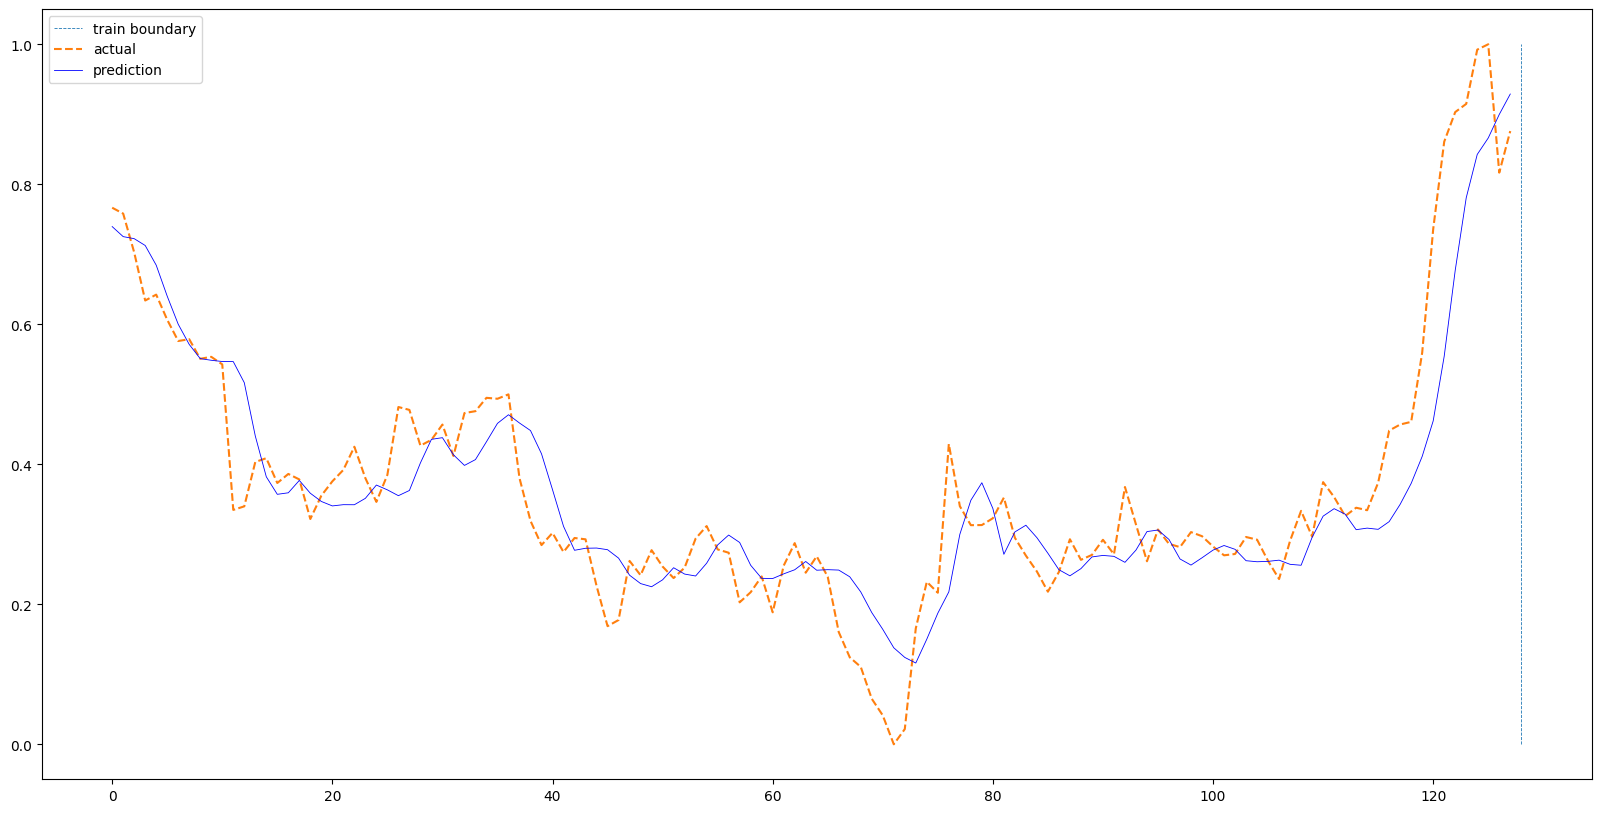

In [ ]:
# train과 test 데이터셋을 하나로 합침
concatdata = torch.utils.data.ConcatDataset([train, test])

# 합쳐진 데이터셋을 DataLoader로 변환, 배치 크기는 100으로 설정, shuffle 옵션은 False
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

# 모델 평가 모드로 설정, 그래디언트 계산 비활성화
with torch.no_grad():
    pred = []  # 예측값을 저장할 리스트 초기화
    model.eval()  # 모델 평가 모드 설정

    # 데이터 로더에서 배치 데이터 반복
    for data in data_loader:
        seq, target = data  # 배치 데이터 (입력 시퀀스, 목표 값)

        # 모델 예측값 계산
        out = model(seq)

        # 예측값을 리스트에 추가 (CPU로 이동하여 리스트 형태로 변환)
        pred += out.cpu().tolist()

# 시각화 설정
plt.figure(figsize=(20,10))

# train 데이터와 test 데이터 경계를 점선으로 표시
plt.plot(np.ones(100) * len(train), np.linspace(0, 1, 100), '--', linewidth=0.6)

# 실제 'Close' 값 점선으로 표시 (시퀀스 길이 이후 값)
plt.plot(df['Close'][sequence_length:].values, '--')

# 예측값 파란색 실선으로 표시
plt.plot(pred, 'b', linewidth=0.6)

# 범례 추가
plt.legend(['train boundary', 'actual', 'prediction'])

# 그래프 출력
plt.show()
